# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Space is a valuable resource for any business that deals in physical goods or presence, even more so for businesses dealing in large and heavy goods, such as cars, and this goes double for low margin businesses, such as used car dealerships. So it behooves used car dealerships to make the most out of every spot they have available on their lots and be able to move inventory constantly to generate revenue instead of sitting on the lot, representing an ever-growing opportunity cost over a more easily moved car sold at a high price. 

To make the most use of a lot spot for a used car, dealerships must try to maximize the revenue generated by that spot by selling cars constantly at high price. Cars that stick around too long or are sold at too low a price can lose money for the dealership.

The question to answer here is: What other features or combinations of features in the dataset correspond with price? Given the dataset about vehicles, pick relevant features and build a statistical model to determine what maximizes price. After scaling features to similar scales, build the model and determine which have the biggest coefficients, which translates to having the most effect on the price which in turn can be indentified and reported to the used car dealerships.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [8]:
#Importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn import set_config
set_config(display="diagram")

Exploring and loading the dataset:

In [10]:
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [11]:
# Taking a look at the last couple of rows of the dataset.
vehicles.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


One thing that immediately jumped out was the manufacturer column, which would be more accurately named the 'marque' column, since some marques are manufactured by the same company, such as all Lexus cars being manufactured by and sharing most of their parts with Toyota cars. For the sake of this project however, the column will remain 'manufacturer.'

The first step is to see if there are any features that do not seem to have even the most tangential relation to price, such as VIN, or vehicle identification number. Perhaps an extremely studious buyer would check VINs against a list of VINs recalled by manufacturers, but the exact number is irrelevant to the price. 'id' is also an irrelevant feature for the same reason.

In theory, location and region the car was listed in would also be important because buyers typically look closer to homes for cars, and local income levels affect prices, but the business case did not state a particular location. Used car dealers also cannot change their location on a whim, and their request is how to go about being more selective with about which cars they take in to eventually sell. As a result, without a clearer idea of where the dealers are located nor the time to curate models for each region, region and state are dropped.

The next step is to consider if any of the features seem redundant. Size is not only missing from most of the dataset, but eclipsed by type (sedan, pickup, truck, SUV, etc.), since type will also communicate the size of the vehicle, so size is a candidate to be dropped.

Finally, any feature with insufficient data must be dealt with in some way, such as cylinders and drive. Both can be inferred to some extent by manufacturer, model, and type, but cannot be determined exactly. However, almost half the entries do not have it, and they likely do not influence price in a way that isn't already captured by manufacturer and type. Paint color is also something missing from large portions of the dataset and is something usually much more important to new car buyers than used car buyers and so will be dropped.

In [13]:
vehicles_drop = vehicles.drop(columns=['id','VIN','size','cylinders','drive','paint_color','region','state']) #dropping features identified above

In [14]:
vehicles_drop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         426880 non-null  int64  
 1   year          425675 non-null  float64
 2   manufacturer  409234 non-null  object 
 3   model         421603 non-null  object 
 4   condition     252776 non-null  object 
 5   fuel          423867 non-null  object 
 6   odometer      422480 non-null  float64
 7   title_status  418638 non-null  object 
 8   transmission  424324 non-null  object 
 9   type          334022 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 32.6+ MB


Of the features left that are still missing from large portions of the dataset, condition is intuitively very important to the price, but with it missing from 40% of entries with no obvious ways to infer it from other columns, instead of being dropped, all empty entries will be filled in with 'unknown,' which is a perfectly valid status for a used car to have when a buyer looks at listings and decides if the car is worth the price. The title_status column, which records the status of the cars title, is similarly important to the value of a used car, and so will be treated similarly by filling in NaN entries with 'unknown.'

In [16]:
vehicles_drop = vehicles_drop.fillna({'condition': 'unknown', 'title_status':'unknown'})

To model price, it is important to understand what the price distribution of the dataset looks like, leading to the following box plot:

Text(0, 0.5, '$USD')

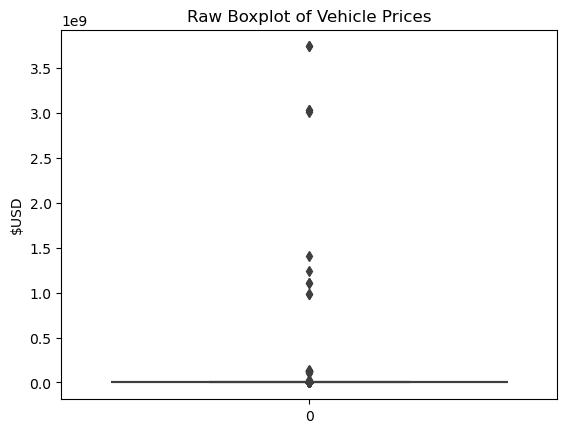

In [18]:
sns.boxplot(data=vehicles_drop['price'])
plt.title("Raw Boxplot of Vehicle Prices")
plt.ylabel("$USD")


The plot indicates there are cars costing almost \\$4 billion dollars in this dataset, which is absurd. The following table presents a closer look at the most expensive cars in this dataset:

In [20]:
vehicles_drop.sort_values('price',ascending=False).head(10) #10 most expensive cars

,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type
318592,3736928711,2007.0,toyota,tundra,excellent,gas,164000.0,clean,automatic,pickup
356716,3736928711,1999.0,toyota,4runner,fair,gas,211000.0,clean,automatic,NaN
257840,3024942282,2000.0,mercedes-benz,benz s430,unknown,gas,100000.0,clean,automatic,NaN
91576,3024942282,2000.0,mercedes-benz,benz e320,unknown,gas,100000.0,clean,automatic,NaN
37410,3009548743,2021.0,chevrolet,NaN,unknown,gas,1000.0,clean,automatic,NaN
184704,1410065407,1989.0,jeep,wrangler,unknown,diesel,103000.0,clean,manual,SUV
153082,1234567890,2006.0,volvo,vnl,fair,other,200000.0,clean,manual,NaN
29386,1111111111,1999.0,ford,f350 super duty lariat,good,diesel,149000.0,clean,automatic,pickup
37409,1111111111,2020.0,jeep,NaN,unknown,gas,1000.0,clean,automatic,NaN
122470,987654321,1960.0,chevrolet,NaN,unknown,gas,9999999.0,clean,manual,NaN


Now, Toyotas are known to retain high resale value, but even new Toyota Tundras are merely $40,000, and not anywhere near the price Disney paid to buy Lucasfilm or Marvel Studios at \\$4 billion each. A closer look at those prices reveals they are 10 digit numbers, or phone numbers inputted into the price column.
Looking at the cheapest cars reveals a similar problem:

In [22]:
vehicles_drop.sort_values('price',ascending=False).tail(10) # 10 cheapest cars in the dataset

,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type
50361,0,2019.0,ford,super duty f-350 dually,excellent,diesel,66064.0,clean,automatic,truck
213532,0,2014.0,ram,NaN,unknown,diesel,0.0,clean,automatic,other
364956,0,2016.0,toyota,rav4 xle,unknown,gas,102000.0,clean,automatic,SUV
50373,0,2007.0,lexus,rx,unknown,gas,238883.0,clean,automatic,wagon
364963,0,2016.0,NaN,2016 and Up Models,unknown,gas,69091.0,clean,automatic,NaN
364967,0,2017.0,nissan,altima,unknown,gas,127000.0,clean,automatic,NaN
364970,0,2014.0,mercedes-benz,s-class,unknown,gas,59884.0,clean,automatic,sedan
17307,0,2005.0,nissan,350z 2dr coupe,good,other,65826.0,clean,automatic,coupe
17306,0,2009.0,gmc,sierra 1500 2dr pickup,good,other,89432.0,clean,automatic,pickup
52747,0,2016.0,mini,cooper hardtop s,unknown,gas,31681.0,clean,automatic,hatchback


There are a lot of cars listed at 0 dollars, or free that should be excluded from the set. 
Using a cutoff points of \\$200,000 dollars maximum and \\$1000 minimum, the following box plot is produced:

In [24]:
vehicles_price_cutoff = vehicles_drop[(vehicles_drop['price'] < 200001) & (vehicles_drop['price'] > 999)]

Text(0, 0.5, '$USD')

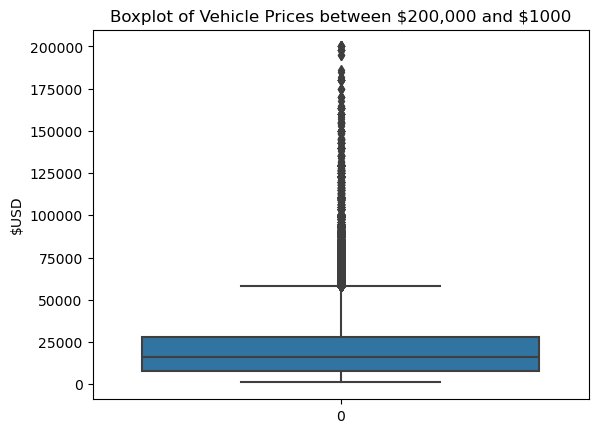

In [25]:
sns.boxplot(data=vehicles_price_cutoff['price'])
plt.title("Boxplot of Vehicle Prices between \\$200,000 and \\$1000")
plt.ylabel("$USD")

The lower quartile appearing distinct from the lower maximum is a sign that a \\$1000 cutoff works well to eliminate the cars being thrown around for free or token fees, but the number of outliers on the upper end indicates the maximum cutoff can be further reduced to about \\$60,000, cutting out a lot of outliers. Such low sample sizes at the extreme ranges would not produce a useful model.

Text(0, 0.5, '$USD')

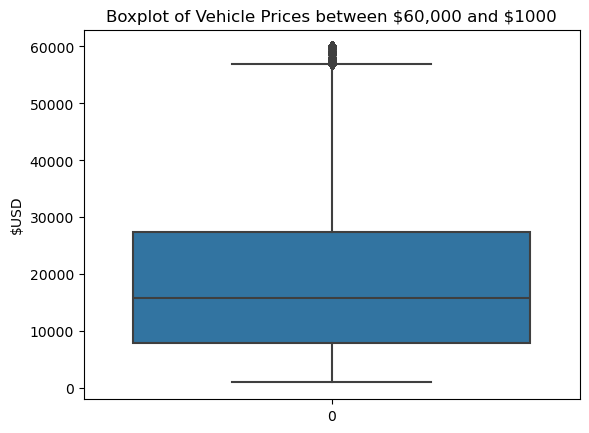

In [27]:
vehicles_price_cutoff = vehicles_price_cutoff[(vehicles_price_cutoff['price'] < 60001)]
sns.boxplot(data=vehicles_price_cutoff['price'])
plt.title("Boxplot of Vehicle Prices between \\$60,000 and \\$1000")
plt.ylabel("$USD")

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Price ($USD)')

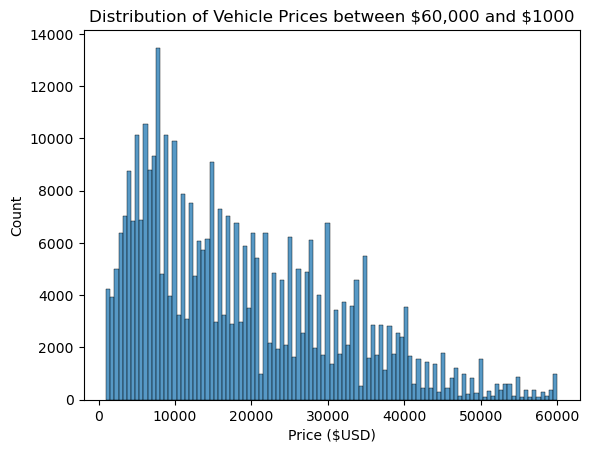

In [28]:
sns.histplot(data=vehicles_price_cutoff['price'])
plt.title("Distribution of Vehicle Prices between \\$60,000 and \\$1000")
plt.xlabel("Price ($USD)")

The resulting histogram shows the distribution to be left skewed towards cheaper prices, which brings up the idea of applying a logrithmic transformation to make the distribution more normal.

In [30]:
vehicles_price_cutoff.info() #see which columns still have a lot of nulls

<class 'pandas.core.frame.DataFrame'>
Index: 374299 entries, 0 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         374299 non-null  int64  
 1   year          373289 non-null  float64
 2   manufacturer  359772 non-null  object 
 3   model         370088 non-null  object 
 4   condition     374299 non-null  object 
 5   fuel          371737 non-null  object 
 6   odometer      372281 non-null  float64
 7   title_status  374299 non-null  object 
 8   transmission  372526 non-null  object 
 9   type          294353 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 39.5+ MB


Now to consider the odometer values:

Text(0, 0.5, 'Miles')

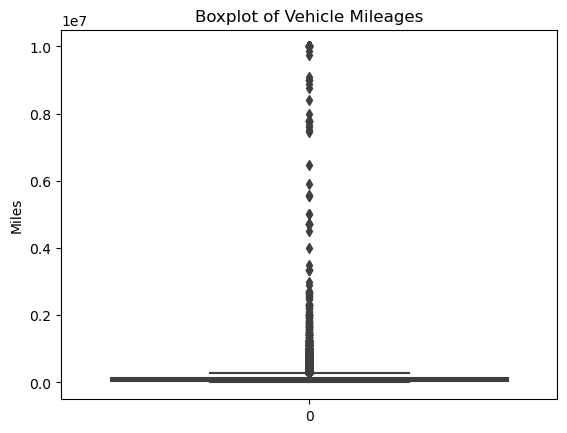

In [32]:
sns.boxplot(data=vehicles_price_cutoff['odometer'])
plt.title("Boxplot of Vehicle Mileages")
plt.ylabel("Miles")

The boxplot of the odometer column shows similar behavior to the price column, where there are some absurd values.

Looking more closely, the odometer column lists almost 100 cars with 10 million miles on their odometers, which would be the equivalent of 20 round trips to the moon and is ludirous, as well as cars with 0 miles. Cutting off the odometer column maximum at 400 thousand miles at maximum and at 10 on the low end, since used car dealers will be selling cars with at least some miles on them, seems a reasonable compromise to remove these troublesome entries.

In [34]:
odometer_cutoff = vehicles_price_cutoff[(vehicles_price_cutoff['odometer'] < 400001) & (vehicles_price_cutoff['odometer'] > 9)]
odometer_cutoff.info()

<class 'pandas.core.frame.DataFrame'>
Index: 368014 entries, 27 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         368014 non-null  int64  
 1   year          367071 non-null  float64
 2   manufacturer  354523 non-null  object 
 3   model         364040 non-null  object 
 4   condition     368014 non-null  object 
 5   fuel          365769 non-null  object 
 6   odometer      368014 non-null  float64
 7   title_status  368014 non-null  object 
 8   transmission  366597 non-null  object 
 9   type          290433 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 30.9+ MB


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Mileage')

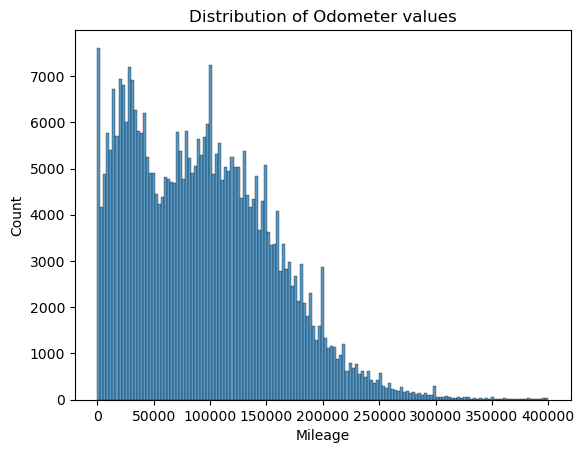

In [35]:
sns.histplot(data=odometer_cutoff['odometer'].reset_index()['odometer'])
plt.title("Distribution of Odometer values")
plt.xlabel("Mileage")

This graph looks much more like a normal curve than the price column, only being cut off by negative mileages being impossible, so only standard nomralizing scaling is needed.

Looking at the fuel column reveals that almost all of the cars labelled as 'other' are actually gas cars, as shown by the models being conventional gasoline models like Chevrolet Colorados or Toyota Tacomas/Tundras:

In [38]:
odometer_cutoff[odometer_cutoff['fuel'] == 'other']

,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type
40,30990,2016.0,chevrolet,colorado crew cab z71,good,other,34940.0,clean,other,pickup
41,27990,2014.0,toyota,tacoma access cab pickup,good,other,17805.0,clean,other,pickup
43,33590,2014.0,toyota,tundra crewmax sr5 pickup,good,other,55251.0,clean,other,pickup
44,30990,2019.0,ford,ranger supercrew xl pickup,good,other,1834.0,clean,other,pickup
48,30590,2016.0,toyota,tacoma double cab sr5,good,other,30176.0,clean,other,pickup
...,...,...,...,...,...,...,...,...,...,...
426819,21990,2016.0,bmw,3 series 328i sedan 4d,good,other,26599.0,clean,automatic,sedan
426861,30990,2019.0,alfa-romeo,romeo giulia ti sedan 4d,good,other,3883.0,clean,other,sedan
426865,34590,2020.0,alfa-romeo,romeo giulia sedan 4d,good,other,2498.0,clean,other,sedan
426867,28990,2018.0,jaguar,xe 25t prestige sedan 4d,good,other,16841.0,clean,other,sedan


This could be a result of some newer US car engines being made to support both regular gasoline and 85% ethanol 15% gasoline blends, but in practice are almost always fueled by gasoline. Another possibility are cars requiring premium fuel such as the BMW 3 series, which is still gas, so all occurances of 'other' will be replaced by 'gas.'

In [40]:
fuel_remove_other = odometer_cutoff.copy()
fuel_remove_other["fuel"] = np.where(fuel_remove_other['fuel'].str.contains('other',na=False, case=False), 'gas', fuel_remove_other.fuel)
fuel_remove_other["transmission"] = np.where(fuel_remove_other['transmission'].str.contains('other',na=False, case=False), 'automatic', fuel_remove_other.transmission)

In [41]:
fuel_remove_other[fuel_remove_other['type'] == 'other']

,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type
36,38590,2011.0,chevrolet,corvette grand sport,good,gas,30237.0,clean,automatic,other
38,32990,2017.0,jeep,wrangler unlimited sport,good,gas,30041.0,clean,automatic,other
52,31590,2020.0,mazda,mx-5 miata club,good,gas,2195.0,clean,automatic,other
56,16590,2016.0,jeep,renegade sport suv 4d,good,gas,35835.0,clean,automatic,other
63,34990,2018.0,ford,mustang gt premium,good,gas,18650.0,clean,automatic,other
...,...,...,...,...,...,...,...,...,...,...
426858,51990,2020.0,cadillac,xt6 premium luxury,good,gas,6814.0,clean,automatic,other
426859,48590,2020.0,cadillac,xt6 premium luxury,good,gas,7701.0,clean,automatic,other
426860,39990,2017.0,infiniti,qx80 sport utility 4d,good,gas,41664.0,clean,automatic,other
426866,32990,2016.0,infiniti,qx80 sport utility 4d,good,gas,55612.0,clean,automatic,other


Another important consideration is the car model recorded in the model column (and not to be confused with the statistical model that will be created later on). While most rows do have it, there are many mispellings of the same model, and the model itself can be roughly inferred by manufacturer and type, like a Toyota sedan is very likely to be a Camry. This also side steps the variant or mispelled names by which a Camry might be listed under, like Camary, CAMARY, 'toyoya camary' and so on. Similarly, a used car buyer looking for a much rarer kind of Toyota sedan, such as a Toyota Crown will also consider the Camry. 

The dataset also contains a number of Scion marque models, some of which are listed under Toyota as the manufacturer as seen below, while others do not have a manufacturer value, and will all be eventually filled in with 'toyota' to create consistency and reflect how Scion was spun off by Toyota in 2003 and was discontinued and rolled back into Toyota in 2016.

In [43]:
scion_df = fuel_remove_other[fuel_remove_other['model'].str.contains('scion',na=False, case=False)]
scion_df.sort_values('manufacturer',ascending=False)

,price,year,manufacturer,model,condition,fuel,odometer,title_status,transmission,type
4636,3850,2010.0,toyota,scion,good,gas,168000.0,clean,automatic,SUV
294924,9600,2006.0,toyota,scion xb,unknown,gas,91000.0,clean,automatic,NaN
262772,5900,2006.0,toyota,scion xb,excellent,gas,114000.0,clean,automatic,SUV
273282,16985,2013.0,toyota,scion fr-s,unknown,gas,61777.0,clean,manual,coupe
274640,2500,2009.0,toyota,scion tc,good,gas,130000.0,clean,automatic,hatchback
...,...,...,...,...,...,...,...,...,...,...
426225,12590,2012.0,NaN,Scion xD Hatchback 4D,good,gas,60589.0,clean,automatic,hatchback
426550,14000,2013.0,NaN,2013 scion fr-s,excellent,gas,63000.0,clean,manual,coupe
426696,7777,2010.0,NaN,Scion xD,unknown,gas,100643.0,clean,automatic,hatchback
426824,12590,2012.0,NaN,Scion xD Hatchback 4D,good,gas,60589.0,clean,automatic,hatchback


Similarly, other manufacturers are listed or mispelled in the model column and missing in the manufacturer column, but can be recovered by looking at the model column. Other models, such as the F-150, F-250, and so on are Ford's, and so some NaNs in the manufacturer column can be inferred by the model. In theory, more can be done than seen below to fill in the manufacturer column by creating a dictionary of every manufacturer and every model they have produced as well as all mispellings, but at the very least, I have covered some cases I found casually looking through the dataset.

In [45]:
#
model_to_manu_df = fuel_remove_other.copy()

model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('scion',na=False, case=False), 'toyota', model_to_manu_df.manufacturer.copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('scoin',na=False, case=False), 'toyota', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('genesis',na=False, case=False), 'genesis', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('ford',na=False, case=False), 'ford', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('frod',na=False, case=False), 'ford', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('F-[1-6]50',regex = True,na=False, case=False), 'ford', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('F[1-6]50',regex = True, na=False, case=False), 'ford', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('toyoya',na=False, case=False), 'toyota', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('toyota',na=False, case=False), 'toyota', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('toyota',na=False, case=False), 'toyota', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('toyoda',na=False, case=False), 'toyota', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('isuzu',na=False, case=False), 'isuzu', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('suzuki',na=False, case=False), 'suzuki', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('maserati',na=False, case=False), 'maserati', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('hummer',na=False, case=False), 'hummer', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('yamaha',na=False, case=False), 'yamaha', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('wrangler',na=False, case=False), 'jeep', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('volvo',na=False, case=False), 'volvo', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('bentley',na=False, case=False), 'bentley', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('bmw',na=False, case=False), 'bmw', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('wagen',na=False, case=False), 'volkswagen', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('kwagon',na=False, case=False), 'volkswagen', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('beetle',na=False, case=False), 'volkswagen', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('saab',na=False, case=False), 'saab', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('mazda',na=False, case=False), 'mazda', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('madza',na=False, case=False), 'mazda', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].str.contains('oldsmobile',na=False, case=False), 'oldsmobile', model_to_manu_df['manufacturer'].copy())
model_to_manu_df["manufacturer"] = np.where(model_to_manu_df['model'].isin(['500']), 'fiat', model_to_manu_df['manufacturer'].copy())
model_to_manu_df = model_to_manu_df[~model_to_manu_df.model.str.contains("#NAME?", na=False)]

In [46]:
model_to_manu_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 367977 entries, 27 to 426879
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         367977 non-null  int64  
 1   year          367034 non-null  float64
 2   manufacturer  360177 non-null  object 
 3   model         364003 non-null  object 
 4   condition     367977 non-null  object 
 5   fuel          365732 non-null  object 
 6   odometer      367977 non-null  float64
 7   title_status  367977 non-null  object 
 8   transmission  366560 non-null  object 
 9   type          290414 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 30.9+ MB


Now that information has been extracted from the model column into the manufacturer column, it can be safely dropped:

In [48]:
model_to_manu_df = model_to_manu_df.drop(columns=['model'])

Now, dropping all remaining rows with nulls to arrive at the dataset the model will be built on.

In [50]:
model_to_manu_df = model_to_manu_df.dropna()

In [51]:
model_to_manu_df.info() #verify there are no nulls

<class 'pandas.core.frame.DataFrame'>
Index: 282422 entries, 27 to 426879
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         282422 non-null  int64  
 1   year          282422 non-null  float64
 2   manufacturer  282422 non-null  object 
 3   condition     282422 non-null  object 
 4   fuel          282422 non-null  object 
 5   odometer      282422 non-null  float64
 6   title_status  282422 non-null  object 
 7   transmission  282422 non-null  object 
 8   type          282422 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 21.5+ MB


In [52]:
# See what is in each column in preperation for One Hot Encoding:
for col in model_to_manu_df:
    print(col, model_to_manu_df[col].unique(),model_to_manu_df[col].nunique())

price [33590 22590 39590 ...  8179  4760  6328] 11776
year [2014. 2010. 2020. 2017. 2013. 2012. 2016. 2019. 2011. 2018. 2004. 2015.
 2001. 2006. 2003. 2008. 2007. 2005. 2009. 2002. 1998. 1995. 1978. 1999.
 1974. 1996. 1987. 2000. 1955. 1991. 1997. 1972. 1994. 1988. 1968. 1969.
 1979. 1984. 1986. 1989. 1937. 1976. 1953. 1963. 2021. 1993. 1990. 1982.
 1948. 1985. 1951. 1936. 1966. 1981. 1973. 1947. 1992. 1962. 1975. 1958.
 1964. 1933. 1934. 1977. 1971. 1980. 1946. 1967. 1957. 1940. 1930. 1950.
 1959. 1965. 1922. 1928. 1960. 1970. 1929. 1932. 1956. 1924. 1927. 1952.
 1939. 1983. 1923. 1961. 1918. 1900. 1931. 1926. 1954. 1938. 1942. 1949.
 2022. 1935. 1941. 1925. 1905. 1916. 1944.] 103
manufacturer ['gmc' 'chevrolet' 'toyota' 'ford' 'jeep' 'nissan' 'ram' 'mazda'
 'cadillac' 'honda' 'dodge' 'lexus' 'jaguar' 'buick' 'chrysler' 'volvo'
 'audi' 'infiniti' 'lincoln' 'alfa-romeo' 'subaru' 'acura' 'hyundai'
 'mercedes-benz' 'bmw' 'mitsubishi' 'volkswagen' 'porsche' 'kia'
 'maserati' 'saab' 'suzuk

Of note here is that all the model years look fine. There are no cars predating the invention of cars or far in the future and so no further work needs to happen on that column.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

Some preparation was done to eliminate nulls from the dataset and fill in at least some missing manufacturer information based on information from the full dataset. Now, as mentioned above, both price distribution was skewed left, so a logrithmic transformation would help the set become more of a normal curve.

In [56]:
df_prep = model_to_manu_df
df_prep['price'] = np.log(df_prep['price']) # price is now logrithmic transformed

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Price log($USD)')

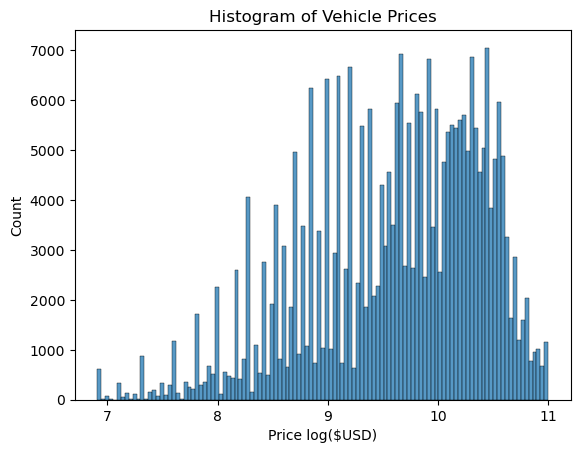

In [57]:
sns.histplot(data=df_prep['price'])
plt.title("Histogram of Vehicle Prices")
plt.xlabel("Price log($USD)")


Model year can also be made into a more relevant statistic by converting model year to age. With the latest year model in the set being:

In [59]:
df_prep['year'].max()

2022.0

, age can be calculated by subtracting the year from 2023:

In [61]:
df_prep['age'] = 2023 - df_prep['year']
df_prep = df_prep.drop(columns=['year']) # drop the year column, since age now captures the same data

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Mileage (miles)')

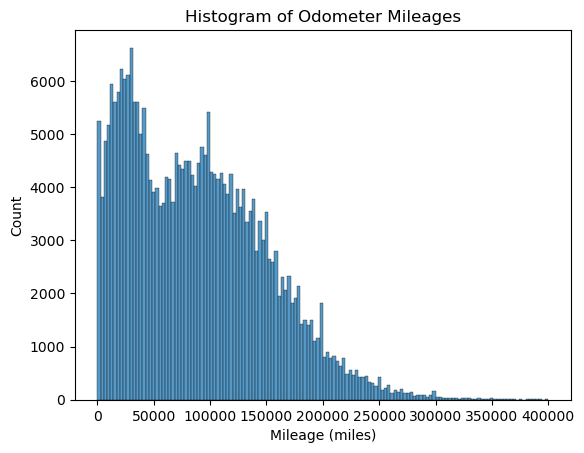

In [62]:
sns.histplot(data=df_prep['odometer'])
plt.title("Histogram of Odometer Mileages")
plt.xlabel("Mileage (miles)")

The non-numerical categories must be dealt with. The one with the most variety, and hence blows up into the most extra columns that require more computation time is the manufacturer column, so it is a good idea to remove the most manufacturers without removing too many entries. Looking at the least frequent marques is a good way to start:

In [64]:
df_prep['manufacturer'].value_counts().tail(10) # 10 least common manufacturers

manufacturer
oldsmobile         231
suzuki             212
harley-davidson     71
bentley             53
datsun              32
yamaha              14
aston-martin         9
land rover           9
ferrari              6
morgan               1
Name: count, dtype: int64

This column can be trimmed down by eliminating those with few entries, such as the 32 entry Datsun, which is Nissan's old name with the name change occuring in 1986. With the jump from 71 Harley-Davidson to 212 Suzuki vehicles, it seems logical to remove all manufacturers less popular than Suzuki to reduce the eventual size of the One-Hot expanded dataset, which removes 8 extra expensive columns to model at the price of only removing less than 200 cars, neglible to model performance.

In [66]:
df_reduced_manu = df_prep[df_prep.groupby('manufacturer').manufacturer.transform('count')>200].copy() 

Now, onto applying the One Hot Encoding the non-numeric features and Standard Scaler to the numeric features:

In [68]:
numeric_features = ["age", "odometer"]

categorical_features = ["manufacturer", "condition", "fuel","title_status","transmission","type"]
preprocessor = ColumnTransformer(
    transformers=[
    ("stdscale", StandardScaler(),numeric_features), # this puts the odometer and age on equal footing when it comes to resulting coefficients
    ("one hot encoder", OneHotEncoder(sparse_output = False),categorical_features)], #turns categories into their columns
    remainder='passthrough' # this is the price, already logrithmic transformed
)
preprocessor.set_output(transform = 'pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('stdscale', StandardScaler(),
                                 ['age', 'odometer']),
                                ('one hot encoder',
                                 OneHotEncoder(sparse_output=False),
                                 ['manufacturer', 'condition', 'fuel',
                                  'title_status', 'transmission', 'type'])])

With these preperations, the model dataset is ready:

In [70]:
df_clean = preprocessor.fit_transform(df_reduced_manu)
df_clean.head()

,stdscale__age,stdscale__odometer,one hot encoder__manufacturer_acura,one hot encoder__manufacturer_alfa-romeo,one hot encoder__manufacturer_audi,one hot encoder__manufacturer_bmw,one hot encoder__manufacturer_buick,one hot encoder__manufacturer_cadillac,one hot encoder__manufacturer_chevrolet,one hot encoder__manufacturer_chrysler,...,one hot encoder__type_hatchback,one hot encoder__type_mini-van,one hot encoder__type_offroad,one hot encoder__type_other,one hot encoder__type_pickup,one hot encoder__type_sedan,one hot encoder__type_truck,one hot encoder__type_van,one hot encoder__type_wagon,remainder__price
27,-0.254832,-0.509061,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.421984
28,0.241519,-0.292336,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.025263
29,-0.999360,-1.140426,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.586332
30,-0.627096,-0.782680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.341420
31,-0.130745,0.632340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.615805


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Creating training and testing data to predict price.

In [73]:
X = df_clean.drop(columns=['remainder__price'])
y = df_clean['remainder__price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

The first (, second, third, and fourth) models tried will be Ridge models on alphas 0.1, 1.0, 10.0, and 100.0. With Mean Squared Error as the error evaluator. Car prices and margins from car sales are very competitive and cut-throat, so a method that heavily punishes outliers is appropriate.

In [75]:
params_dict = {'alpha': [0.1, 1.0, 10.0,100.0]}
ridge = Ridge()
grid = GridSearchCV(estimator=ridge,param_grid=params_dict)

grid.fit(X_train,y_train)
train_preds = grid.predict(X_train)
test_preds = grid.predict(X_test)
model_train_mse = mean_squared_error(y_train, train_preds)
model_test_mse = mean_squared_error(y_test, test_preds)
model_best_alpha = grid.best_params_

In [76]:
print(f'Test MSE: {model_test_mse}')
print(f'Best Alpha: {list(model_best_alpha.values())[0]}')

Test MSE: 0.18916699909503196
Best Alpha: 1.0


Best alpha is found to be 1, with full results for the 4 models below:

In [78]:
grid.cv_results_

{'mean_fit_time': array([0.2432785 , 0.24702535, 0.22426772, 0.22619524]),
 'std_fit_time': array([0.04505111, 0.0188695 , 0.00590821, 0.00546361]),
 'mean_score_time': array([0.01504626, 0.01332202, 0.01285267, 0.01291299]),
 'std_score_time': array([0.0059967 , 0.00144309, 0.00089759, 0.00061152]),
 'param_alpha': masked_array(data=[0.1, 1.0, 10.0, 100.0],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.1}, {'alpha': 1.0}, {'alpha': 10.0}, {'alpha': 100.0}],
 'split0_test_score': array([0.69496835, 0.69496455, 0.69491932, 0.69406729]),
 'split1_test_score': array([0.70133987, 0.70134406, 0.7013514 , 0.70058822]),
 'split2_test_score': array([0.69524655, 0.69524943, 0.69525791, 0.69457772]),
 'split3_test_score': array([0.69755768, 0.69755777, 0.69753875, 0.69667732]),
 'split4_test_score': array([0.69410569, 0.69410622, 0.69409401, 0.69338262]),
 'mean_test_score': array([0.69664363, 0.69664441, 0.69663228, 

In [79]:
df_coef = pd.DataFrame(index = X_test.columns) #create dataframe to hold coefficients
df_coef = df_coef.assign(coefficients=grid.best_estimator_.coef_)
# print(df_coef.to_string())

The other model tried is Sequential Feature Selection, selecting 6 features to balance total computation time while still picking up more features.

In [81]:
sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=6)
sfs.fit(X_train,y_train)

SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select=6)

In [82]:
X_test.columns[sfs.get_support(indices=True)]
X_reduced_train = X_train[X_test.columns[sfs.get_support(indices=True)]]
X_reduced_test = X_test[X_test.columns[sfs.get_support(indices=True)]]

In [83]:
lr = LinearRegression()
lr.fit(X_reduced_test,y_test)
print(X_test.columns[sfs.get_support(indices=True)])
print(lr.coef_)

Index(['stdscale__age', 'stdscale__odometer',
       'one hot encoder__condition_fair', 'one hot encoder__fuel_diesel',
       'one hot encoder__type_hatchback', 'one hot encoder__type_sedan'],
      dtype='object')
[-0.22313331 -0.43356183 -0.68586724  0.7819486  -0.50179726 -0.4410559 ]


Sequential Feature Selector (SFS) pointed out the 'fair' condition, age, odometer, sedans, hatchbacks as big negatives, while finding diesel as a large positive. This matches the conclusions reached from the full ridge model.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

The models will be evaluated on their test data mean squared error, a part of the dataset that the models were not trained on, yet will need to predict accurately. As explained above, severely mispredicting the price can quickly snowball into a failed business, so a method that heavily punishes large errors in appropriate.

In [87]:
print(f'Ridge Model Test MSE: {model_test_mse}') #MSE for the Ridge model

Ridge Model Test MSE: 0.18916699909503196


In [88]:
sequential_reduced_train_mse = mean_squared_error(y_train,lr.predict(X_reduced_train)) #MSE for SFS +linear model
sequential_reduced_test_mse = mean_squared_error(y_test,lr.predict(X_reduced_test))
print(f'Sequential Feature Selection Test MSE: {sequential_reduced_test_mse}')

Sequential Feature Selection Test MSE: 0.24433731889522325


With an test MSE of 0.189, the Ridge Regression model with alpha = 1.0 on all remaining features seems to do best compared to Sequential 6 Feature Selection into linear regression at a test MSE of 0.244. Both are fairly accurate, and Ridge Regression ran much faster than the second method. With the lower Mean Squared Error, the Ridge model will be used for the rest of this evaluation.

In [90]:
df_coef.sort_values('coefficients', ascending = False) #sort coefficients from high to low, see top 5 and bottom 5

,coefficients
one hot encoder__manufacturer_tesla,0.793529
one hot encoder__manufacturer_hummer,0.589570
one hot encoder__manufacturer_maserati,0.517178
one hot encoder__manufacturer_porsche,0.466241
one hot encoder__fuel_diesel,0.453583
...,...
one hot encoder__condition_fair,-0.507981
one hot encoder__manufacturer_saab,-0.528929
one hot encoder__title_status_parts only,-0.535326
one hot encoder__manufacturer_suzuki,-0.612211


So, checking the coefficients generated by the ridge model shows the biggest coefficients, whether negative or positive, have a match on the 'fair' condition with 6-feature SFS, which indicates the model is on the right track. It also clearly deliniates various the effects of various manufacturers, types, conditions, and so on as well as:

In [92]:
print(df_coef[df_coef.index.str.contains('stdscale_')].sort_values('coefficients',ascending=False))

                    coefficients
stdscale__age          -0.207750
stdscale__odometer     -0.424828


clear coefficients for the numeric features and trends the numeric features cause in price. With the effects of all the different categories found in the resulting coefficients, there does not appear to be any reasons to revisit previous steps.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Here is a ranking of Marques (called manufacturers in the dataset). The higher the value, the more money a car with that marque sells for on the used car market. From most valuable to least, they are:

In [96]:
print(df_coef[df_coef.index.str.contains('one hot encoder__manufacturer_')].sort_values('coefficients',ascending=False))

                                             coefficients
one hot encoder__manufacturer_tesla              0.793529
one hot encoder__manufacturer_hummer             0.589570
one hot encoder__manufacturer_maserati           0.517178
one hot encoder__manufacturer_porsche            0.466241
one hot encoder__manufacturer_lexus              0.367757
one hot encoder__manufacturer_alfa-romeo         0.365828
one hot encoder__manufacturer_genesis            0.299877
one hot encoder__manufacturer_rover              0.276821
one hot encoder__manufacturer_audi               0.244251
one hot encoder__manufacturer_mercedes-benz      0.215782
one hot encoder__manufacturer_jaguar             0.203808
one hot encoder__manufacturer_cadillac           0.189769
one hot encoder__manufacturer_infiniti           0.189138
one hot encoder__manufacturer_bmw                0.154524
one hot encoder__manufacturer_acura              0.123492
one hot encoder__manufacturer_lincoln            0.103661
one hot encode

According to the model that was best able to predict price, used car dealerships should look for **Tesla, Hummer, Maserati, Porsche, Lexus,** and **Alfa-Romeo** marque cars, all luxury/more specialized cars, and avoid **Fiat, Mercury, Saab, Suzuki, and Saturn**, which with the exception of Suzuki, have poor reliability and reputation. 

Fiat in particular  historically earned a nickname in the United States: "**F**ix **I**t **A**gain **T**ony" through World War I when its cars stopped being sold in the United States, and that perception appears to have continued for its used cars and reentry into the US market in 2009 after buying a 20% stake in Chrysler in a US-brokered deal to bailout the troubled American compnay.

For non-luxury brands, GMC, Jeep, Toyota, and Ram are good choices and are more generally more available than the luxury marques.

Now consider car **type**:

In [98]:
print(df_coef[df_coef.index.str.contains('one hot encoder__type_')].sort_values('coefficients',ascending=False))

                                   coefficients
one hot encoder__type_truck            0.369638
one hot encoder__type_pickup           0.315147
one hot encoder__type_offroad          0.271646
one hot encoder__type_bus              0.256485
one hot encoder__type_other            0.074524
one hot encoder__type_van              0.009913
one hot encoder__type_coupe            0.005061
one hot encoder__type_convertible      0.004938
one hot encoder__type_SUV             -0.070089
one hot encoder__type_wagon           -0.218168
one hot encoder__type_mini-van        -0.280462
one hot encoder__type_sedan           -0.364355
one hot encoder__type_hatchback       -0.374279


When considering between different car types, choose trucks, pickups, off-roaders, and generally larger and cars. Customers will be willing to put up more money for more car, which means hatchbacks and sedans are to be ignored. Of special case is the minivan, which is large, but is almost as undesirable as a sedan.

In [100]:
print(df_coef[df_coef.index.str.contains('one hot encoder__fuel_')].sort_values('coefficients',ascending=False))

                                coefficients
one hot encoder__fuel_diesel        0.453583
one hot encoder__fuel_gas          -0.120758
one hot encoder__fuel_hybrid       -0.139245
one hot encoder__fuel_electric     -0.193579


Fuel type-wise, diesel also commands a premium compared to other fuel types while pure electric cars have a slight penalty compared to gas and hybrid cars, possibly due to greater fears of battery degredation and that most non-Tesla electric cars are of the low-cost budget type already, such as the Nissan Leaf.

In [102]:
print(df_coef[df_coef.index.str.contains('one hot encoder__condition_')].sort_values('coefficients',ascending=False))

                                      coefficients
one hot encoder__condition_unknown        0.283237
one hot encoder__condition_new            0.212534
one hot encoder__condition_excellent      0.198776
one hot encoder__condition_good           0.176388
one hot encoder__condition_like new       0.143931
one hot encoder__condition_salvage       -0.506885
one hot encoder__condition_fair          -0.507981


Condition is generally self-explanatory, with the 'new' or 'excellent' topping the charts, but interestingly cars in the dataset that did not have a condition listed at all sold at the best prices. Perhaps this reflects ceertain sellers selling particular cars they are confident in and know that buyers will come regardless of condition.

In [104]:
print(df_coef[df_coef.index.str.contains('one hot encoder__title_status_')].sort_values('coefficients',ascending=False))

                                          coefficients
one hot encoder__title_status_lien            0.287009
one hot encoder__title_status_clean           0.239818
one hot encoder__title_status_unknown         0.186369
one hot encoder__title_status_missing         0.005911
one hot encoder__title_status_rebuilt        -0.034045
one hot encoder__title_status_salvage        -0.149737
one hot encoder__title_status_parts only     -0.535326


Nothing suprising about title status. Cars taken on lien and having clean titles are very desirable, while unknown or missing titles are neutral, and cars that have had a history of significant damage are negative.

In [106]:
print(df_coef[df_coef.index.str.contains('one hot encoder__transmission_')].sort_values('coefficients',ascending=False))

                                         coefficients
one hot encoder__transmission_manual         0.021379
one hot encoder__transmission_automatic     -0.021379


With the improvement of automatic transmissions in the 1980s and 1990s as well as being cheaper, manual transmissions have become much more rare while being more fun to drive, so it has become a prized feature among car buyers who want a manual transmission in their next car, commanding a premium compared to automatic transmissions.

In [108]:
print(df_coef[df_coef.index.str.contains('stdscale_')].sort_values('coefficients',ascending=False))

                    coefficients
stdscale__age          -0.207750
stdscale__odometer     -0.424828


Meanwhile, increasing age and mileage both drop the price of a used car, but mileage matters much more than age, which is generally in line with conventional wisdom.

In conclusion, to maximize the price a car is sold at in a particular lot spot, consider the following in order of importance: get luxury or Tesla marques if possible, which have a higher base price to drop from, get cars that run on diesel, get big cars, in good or better condition, clean title status, and manual transmissions. Conventional wisdom about mileage mattering more than age continues to hold.

Conversely, avoid marques with bad reputation as seen the ranking above, avoid small boring cars like sedans or hatchbacks, avoid non-Tesla electric cars, and cars with poor titles/histories.

Ideal next steps would be to narrow down use case by region. Since used car dealers do not generally sell to the entire United States, it is possible to improve performance by creating 50 different models for the 50 different states or possibly something more broad like the Midwestern states, and build many different models for many different regions. Intuitively, sunny California cares less about big work trucks than Michigan, so having more precise modeling for each region can help used car dealers more precisely target local buyers and better match the prices their local competitors are asking for.